<a href="https://colab.research.google.com/github/TBKHori/Music-Recon13/blob/main/DQN_and_Double_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization

!pip install "stable-baselines3[extra]>=2.0.0a4"
!pip install -U tensorboard-plugin-profile

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  freeglut3 libegl-dev libfontenc1 libgl-dev libgl1-mesa-dev libgles-dev
  libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev
  libglx-dev libice-dev libopengl-dev libsm-dev libxfont2 libxkbfile1
  libxt-dev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
Suggested packages:
  libice-doc libsm-doc libxt-doc
The following NEW packages will be installed:
  freeglut3 freeglut3-dev libegl-dev libfontenc1 libgl-dev libgl1-mesa-dev
  libgles-dev libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev
  libglvnd-dev libglx-dev libice-dev libopengl-dev libsm-dev libxfont2
  libxkbfile1 libxt-dev x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 25 newly installed, 0 to remove and 16 not upgraded.
Ne

In [10]:
import gymnasium as gym
import numpy as np
import torch as th
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


The Mountain Car Problem

In this environment, the agent must drive an underpowered car up a steep mountain road. For any given state the agent may choose to accelerate to the left, right or cease any acceleration.

Source: https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/mountain_car.py

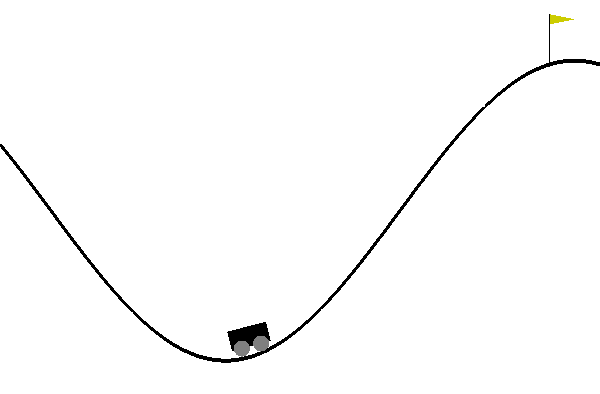

Observation:
    Type: Box(2)
    Num    Observation               Min            Max
    0      Car Position              -1.2           0.6
    1      Car Velocity              -0.07          0.07
Actions:
    Type: Discrete(3)
    Num    Action
    0      Accelerate to the Left
    1      Don't accelerate
    2      Accelerate to the Right
    Note: This does not affect the amount of velocity affected by the
    gravitational pull acting on the car.
Reward:
     Reward of 0 is awarded if the agent reached the flag (position = 0.5)
     on top of the mountain.
     Reward of -1 is awarded if the position of the agent is less than 0.5.
Starting State:
     The position of the car is assigned a uniform random value in
     [-0.6 , -0.4].
     The starting velocity of the car is always assigned to 0.
Episode Termination:
     The car position is more than 0.5
     Episode length is greater than 200

In [11]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")

```yaml
MountainCar-v0:
  n_timesteps: !!float 1.2e5
  policy: 'MlpPolicy'
  learning_rate: !!float 4e-3
  batch_size: 128
  buffer_size: 10000
  learning_starts: 1000
  gamma: 0.98
  target_update_interval: 600
  train_freq: 16
  gradient_steps: 8
  exploration_fraction: 0.2
  exploration_final_eps: 0.07
  policy_kwargs: "dict(net_arch=[256, 256])"
```

In [12]:
tensorboard_log = "data/tb/"

In [13]:
dqn_model = DQN(
    "MlpPolicy",
    env,
    verbose=1,
    train_freq=16,
    gradient_steps=8,
    gamma=0.99,
    exploration_fraction=0.2,
    exploration_final_eps=0.07,
    target_update_interval=600,
    learning_starts=1000,
    buffer_size=10000,
    batch_size=128,
    learning_rate=4e-3,
    policy_kwargs=dict(net_arch=[256, 256]),
    tensorboard_log=tensorboard_log,
    seed=2,
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [14]:
mean_reward, std_reward = evaluate_policy(
    dqn_model,
    dqn_model.get_env(),
    deterministic=True,
    n_eval_episodes=20,
)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-200.00 +/- 0.00


In [15]:
dqn_model.learn(int(1.2e5), log_interval=10)

Logging to data/tb/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.922    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 545      |
|    time_elapsed     | 3        |
|    total_timesteps  | 2000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 1.97e-05 |
|    n_updates        | 496      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.845    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 461      |
|    time_elapsed     | 8        |
|    total_timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 9.68e-

In [17]:
mean_reward, std_reward = evaluate_policy(dqn_model, dqn_model.get_env(), deterministic=True, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-105.20 +/- 22.92


In [18]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [19]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path="", prefix=""):
    """
    Taken from https://github.com/eleurent/highway-env

    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) Filter the video, showing only the only starting with this prefix
    """
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [20]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv


def record_video(
    env_id,
    model,
    video_length=500,
    prefix="",
    video_folder="videos/",
):
    """
    :param env_id: (str)
    :param model: (RL model)
    :param video_length: (int)
    :param prefix: (str)
    :param video_folder: (str)
    """
    eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    # Start the video at step=0 and record 500 steps
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )

    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs, deterministic=False)
        obs, _, _, _ = eval_env.step(action)

    # Close the video recorder
    eval_env.close()

In [21]:
record_video("MountainCar-v0", dqn_model, video_length=500, prefix="dqn-mountaincar")

Saving video to /content/videos/dqn-mountaincar-step-0-to-step-500.mp4
Moviepy - Building video /content/videos/dqn-mountaincar-step-0-to-step-500.mp4.
Moviepy - Writing video /content/videos/dqn-mountaincar-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/dqn-mountaincar-step-0-to-step-500.mp4


In [22]:
show_videos("videos", prefix="dqn")